In [23]:
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from numpy import array, uint8
from matplotlib import axes
import multiprocessing
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2
import sys
import os

In [24]:
image_path = './dataset/original/'
sketch_path = './dataset/sketch/'
drawing_path = './dataset/drawing/'
complete_path = './dataset/complete/'

cores = cpu_count()
img_names = os.listdir(image_path)
img_names_split = np.array_split(img_names, cores)

In [25]:
# if os.path.exists(image_path):
#     shutil.rmtree(image_path, ignore_errors=True)
# os.makedirs(image_path)
# map_path = complete_path + "complete_original.png"
# size = 256
# im = array(Image.open(map_path).convert("RGB"))

# tiles = [im[x:x+size, y:y+size] for x in range(0, im.shape[0], size) for y in range(0, im.shape[1], size)]
# for i in range(0, len(tiles)):
#     tile = tiles[i]
#     result_image = Image.fromarray(tile)
#     result_path = os.path.join(image_path, str(i) + ".png")
#     result_image.save(result_path)

In [26]:
import time


def original(img):
    return cv2.imread(image_path + img)

def burnV2(image, mask):
    return 255 - cv2.divide(255-image, 255-mask, scale=256)

def dodgeV2(image, mask):
    return cv2.divide(image, 255-mask, scale=256)

def img_to_sketch(img):
    img_rgb = cv2.imread(image_path + img)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    img_gray_inv = np.subtract(255, img_gray)
    img_blur = cv2.GaussianBlur(
        img_gray_inv,
        ksize=(21, 21),
        sigmaX=0,
        sigmaY=0
    )
    
    img_blend = dodgeV2(img_gray, img_blur)
    return img_blend
    
    #plt.imsave(sketch_path+'/'+img, img_blend, cmap='gray')
    #plt.imshow( img_blend,cmap='gray')
    #plt.show()

def img_to_drawing(img, blur=15, k=5, passes=100, gaussian=False, bilateral=False, median=True, medianFor=False, kmeans=True, fastNlMeansDenoisingColored=True):
    if type(img) == str:
        image = cv2.imread(image_path + img)
    else:
        image = img

    if gaussian:
        image = cv2.GaussianBlur(image, (15, 15), 0)

    if bilateral:
        image = cv2.bilateralFilter(image, 5, 75, 75)
    
    if fastNlMeansDenoisingColored:
        image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    if median:
        # apply a "median" blur to the image
        image = cv2.medianBlur(image, 3)

    if kmeans:
        h, w = image.shape[:2]
        samples = np.zeros([h * w, 3], dtype=np.float32)
        count = 0

        for x in range(h):
            for y in range(w):
                samples[count] = image[x][y]
                count += 1

        compactness, labels, centers = cv2.kmeans(
            samples,
            k,
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
            passes,
            cv2.KMEANS_RANDOM_CENTERS
        )

        centers = np.uint8(centers)
        image = centers[labels.flatten()].reshape((image.shape))

    
    if median:
        if medianFor:
            for b in range(1, blur, 2):
                # apply a "median" blur to the image
                image = cv2.medianBlur(image, b)
        else:
            image = cv2.medianBlur(image, blur)
    
    return image



# size = 256
# im = array(Image.open(complete_path + "complete_original.png").convert("RGB"))
# tiles = [im[x:x+size, y:y+size] for x in range(0, im.shape[0], size) for y in range(0, im.shape[1], size)]
# for pic in [1, 25, 12]:
#     for i in range(0, 3):
#         f, axes = plt.subplots(1, 2, figsize=(15, 10))
#         axes[0].imshow(cv2.cvtColor(tiles[pic], cv2.COLOR_BGR2RGB))
#         axes[1].imshow(cv2.cvtColor(img_to_drawing(tiles[pic]), cv2.COLOR_BGR2RGB))
#     # plt.imshow(cv2.cvtColor(img_to_sketch("30.png"), cv2.COLOR_BGR2RGB))
#     # plt.show()

In [27]:
def img_to_sketch_parallel(img_names):
    for img_file in tqdm(img_names):
        image = img_to_sketch(img_file)
        
        plt.imsave(sketch_path + img_file, image, cmap='gray')
        #plt.imshow(img_blend, cmap='gray')
        #plt.show()

def img_to_drawing_parallel(img_names):
    for img_file in tqdm(img_names):
        image = img_to_drawing(img_file)
        
        plt.imsave(drawing_path + img_file, image)
        #plt.imshow(img_blend)
        #plt.show()

# if os.path.exists(drawing_path):
#     shutil.rmtree(drawing_path, ignore_errors=True)
# os.makedirs(drawing_path)

# pool = Pool(processes=os.cpu_count())
# pool.map(img_to_drawing_parallel, img_names_split)
# pool.close()
# pool.join()

In [28]:
# vertical_images = []
# for y in range(0, 16):
#     horizontal_images = np.hstack([np.array(Image.open(drawing_path + f"{y*16 + x}.png")) for x in range(0, 16)])
#     vertical_images.append(Image.fromarray(horizontal_images))

# Image.fromarray(np.vstack(vertical_images)).save(complete_path + "complete_drawing.png")

crop_x = 256
crop_y = 256
xy_pairs = []
def get_random_xy_pairs(xmax, ymax):
    pair = (np.random.randint(0, xmax), np.random.randint(0, ymax))
    if pair not in xy_pairs:
        xy_pairs.append(pair)
        return pair
    else:
        return get_random_xy_pairs(xmax, ymax)

def create_random_dataset(amount):
    if os.path.exists(drawing_path):
        shutil.rmtree(drawing_path, ignore_errors=True)
    os.makedirs(drawing_path)

    if os.path.exists(image_path):
        shutil.rmtree(image_path, ignore_errors=True)
    os.makedirs(image_path)

    orig = cv2.imread("./dataset/complete/complete_original.png")
    
    max_x = orig.shape[1] - crop_x
    max_y = orig.shape[0] - crop_y
    for i in range(amount):
        x, y = get_random_xy_pairs(max_x, max_y)
        original_crop = orig[y: y + crop_y, x: x + crop_x]
        drawing_crop = img_to_drawing(original_crop)
        # plt.imshow(drawing_crop)
        # plt.show()
        # plt.imshow(original_crop)
        # plt.show()
        cv2.imwrite("./dataset/original/" + str(i) + ".png", original_crop)
        cv2.imwrite("./dataset/drawing/" + str(i) + ".png", drawing_crop)

create_random_dataset(1000)

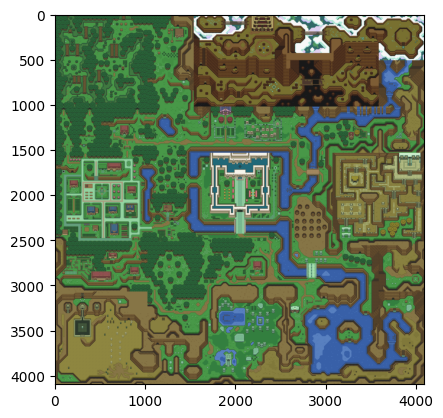

In [29]:
import cv2
import matplotlib.pyplot as plt

orig = cv2.imread("./dataset/complete/complete_original.png")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))

In [30]:
# drawings = os.listdir(drawing_path)
# for i in range(0, len(drawings)):
#     drawing = drawings[i]
#     drawing = cv2.imread(drawing_path + drawing)
#     cv2.imwrite(drawing_path + str(i) + ".png", drawing)

# originals = os.listdir(image_path)
# for i in range(0, len(originals)):
#     original = originals[i]
#     original = cv2.imread(image_path + original)
#     cv2.imwrite(image_path + str(i) + ".png", original)